# Task 1
## Comparing simple recursive algorithm and Kalman filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
def simple_filter(data):
    m = 0
    n = 0
    res = []
    for i in range(len(data)):
        m = (n * m + data[i]) / (n + 1)
        n += 1
        res = np.append(res, m)
    return res

def kalman_filter(u, z, e_std, dt):
    res = [z[0]]
    K = 0

    for i in range(1, len(z)):
        K = e_std**2*res[i-1] / (res[i-1] + e_std**2)
        res = np.append(res, (1-K) * (res[i-1] + u[i] * dt) + K * z[i])

    return res

In [27]:
n_samples = 100
x_min = 0
x_max = 1
a = 5

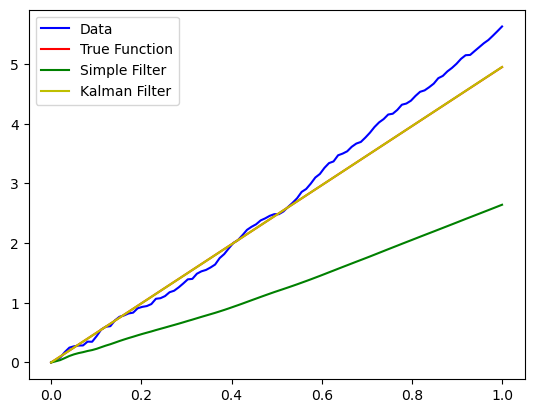

In [33]:
dt = (x_max - x_min) / n_samples
x = np.linspace(x_min, x_max, n_samples)
y_noisy = np.zeros(n_samples)
y_true = np.zeros(n_samples)
for i in range(1, n_samples):
    y_noisy[i] = y_noisy[i - 1] + a * dt + np.random.normal(0, 0.03)
    y_true[i] = y_true[i - 1] + a * dt

y_simple = simple_filter(y_noisy)
y_kalman = kalman_filter(a * np.ones(n_samples), y_noisy, 0.01, (x_max - x_min) / n_samples)


plt.plot(x, y_noisy, 'b', label='Data')
plt.plot(x, y_true, 'r', label='True Function')
plt.plot(x, y_simple, 'g', label='Simple Filter')
plt.plot(x, y_kalman, 'y', label='Kalman Filter')
plt.legend()

# Task 2
## Kalman Filter with GPS Data

Reading and processing GPS data

In [38]:
data = pd.read_csv('data.csv')
data.head()

,time,ax,ay,az,Latitude,Longitude,Speed (m/s),Unnamed: 7
0,0.098634,0.0,0.0,0.0,0.000000,0.000000,0.00,NaN
1,0.160725,0.0,0.0,0.0,55.750242,48.743505,1.27,NaN
2,0.161885,0.0,0.0,0.0,55.750242,48.743505,1.27,NaN
3,0.224515,0.0,0.0,0.0,55.750242,48.743505,1.27,NaN
4,0.225168,0.0,0.0,0.0,55.750242,48.743505,1.27,NaN


In [39]:
ts = np.array(data['time'][1:], dtype=np.float64)
lat = np.array(data['Latitude'][1:], dtype=np.float64)
lon = np.array(data['Longitude'][1:], dtype=np.float64)
accx = np.array(data['ax'][1:], dtype=np.float64)
accy = np.array(data['ay'][1:], dtype=np.float64)
accz = np.array(data['az'][1:], dtype=np.float64)
acc = np.sqrt(accx**2 + accy**2 + accz**2)

In [40]:
def to_meters(lat, lon):
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    R = 6371000
    x = R * lon * np.cos(lat)
    y = R * lat
    return x, y

In [41]:
x, y = to_meters(lat, lon)

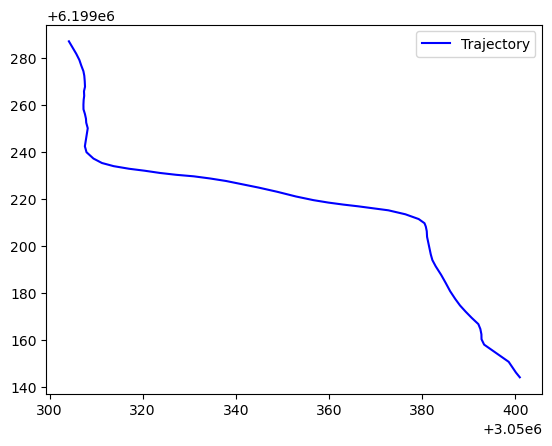

In [88]:
plt.plot(x, y, 'b', label='Trajectory')
plt.legend()
plt.show()

### Implementing Kalman filter

In [62]:
def kalman_filter2(z, A, Q, H, R):
    res = [np.array([z[0][0], 0, 0, z[0][1], 0, 0])]
    P = 0.1 * np.eye(6)
    K = np.zeros((z.shape[0], res[0].shape[0], z.shape[1]))

    for i in range(1, len(z)):
        # Predict
        x_pred = A @ res[i-1]
        P_pred = A @ P @ A.T + Q

        # Update
        K[i] = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        
        # Actual prediciton
        res = np.append(res, [x_pred + K[i] @ (z[i] - H @ x_pred)], axis=0)
        P = (np.eye(6) - K[i] @ H) @ P_pred
    
    return res
    

In [84]:
# x = [x, x', x'', y, y', y'']
# z = [x_gps, y_gps]

dt = ts[1] - ts[0]

A = np.array([
    [1, dt, dt**2/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, dt**2/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1]
])

Q1 = np.expand_dims(np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0]), 1)
Q2 = np.expand_dims(np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt]), 1)

xj = np.zeros(len(ts))
yj = np.zeros(len(ts))

for i in range(1, len(ts)):
    xj[i] = (accx[i] - accx[i - 1]) / (ts[i] - ts[i - 1])
    yj[i] = (accy[i] - accy[i - 1]) / (ts[i] - ts[i - 1])

j_var = max(np.var(xj), np.var(yj))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0]
])

R = np.array([
    [0.1**2, 0],
    [0, 0.1**2]
])

### Filtering the data and plotting results

In [85]:
filtered = kalman_filter2(np.array([x, y]).T, A, Q, H, R)

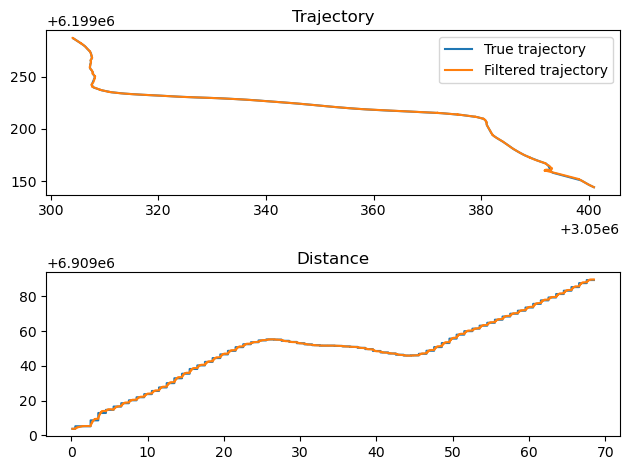

In [86]:
# Plotting predictions versus real values
fig, axs = plt.subplots(2)

axs[0].plot(x, y, label='True trajectory')
axs[0].plot(filtered[:, 0], filtered[:, 3], label='Filtered trajectory')
axs[0].set_title('Trajectory')

# Plot completed distance
axs[1].plot(ts, np.sqrt(x**2 + y**2))
axs[1].plot(ts, np.sqrt(filtered[:, 0]**2 + filtered[:, 3]**2))
axs[1].set_title('Distance')

axs[0].legend()
plt.tight_layout()
plt.show()
